In [53]:
## Install necessary packages if not already installed
## conda installing is very slow, so using pip here
# %pip install matplotlib
# %pip install seaborn
# %pip install rasterstats


In [54]:
import os

import pandas as pd
import geopandas as gpd
import numpy as np

import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats
from rasterio.transform import Affine

from shapely.geometry import mapping
from rasterio.mask import mask

import seaborn as sns
import matplotlib.pyplot as plt

import sys, platform
print("=== Environment Info ===")
print(f"Python envi    : {sys.executable}")
print(f"Python version : {sys.version.split()[0]}")
print(f"Platform       : {platform.platform()}")
print(f"rasterio       : {rasterio.__version__}")
print(f"geopandas      : {gpd.__version__}")
print(f"numpy          : {np.__version__}")
print(f"pandas         : {pd.__version__}")
print(f"matplotlib     : {plt.matplotlib.__version__}")
print(f"seaborn        : {sns.__version__}")
print("========================")


=== Environment Info ===
Python envi    : c:\Users\pc\.conda\envs\geo_env\python.exe
Python version : 3.11.13
Platform       : Windows-10-10.0.22631-SP0
rasterio       : 1.3.10
geopandas      : 0.14.4
numpy          : 1.26.4
pandas         : 2.3.2
matplotlib     : 3.10.6
seaborn        : 0.13.2


In [55]:
from pathlib import Path

# Set the working directory
wd_main     = Path(r"G:\Shared drives\Wellcome Trust Project Data") 
wd_shp      = wd_main / "1_preprocess" / "UrbanCoolingModel" / "OfficialWorkingInputs" / "AOIs"
dir_ucm_out = wd_main / "2_postprocess_intermediate" / "UCM_official_runs"
figures_dir = wd_main / "3_final" / "UCM_figures"

admin_shapefile = wd_shp / "London_Borough_aoi.shp"  # Administrative boundary (e.g., census tracts)
# Load administrative boundaries
aoi_adm = gpd.read_file(admin_shapefile)

### function - short name

In [56]:
import re
from pathlib import Path

def make_short_name(path, base_dir) -> str:
    # --- normalize inputs ---
    # Unwrap single-element tuple/list like (path,) or [path]
    if isinstance(path, (tuple, list)):
        if len(path) == 1:
            path = path[0]
        else:
            raise TypeError(f"Expected a path, got a {type(path).__name__} with len {len(path)}")
    if isinstance(base_dir, (tuple, list)):
        if len(base_dir) == 1:
            base_dir = base_dir[0]
        else:
            raise TypeError(f"Expected a base_dir path, got a {type(base_dir).__name__} with len {len(base_dir)}")

    path = Path(path)
    base_dir = Path(base_dir)

    # find prefix (the first folder under base_dir, e.g. 'current_lulc' or 'scenario2')
    try:
        prefix = path.relative_to(base_dir).parts[0]
    except Exception:
        # fallback: immediate parent if not under base_dir
        prefix = path.parent.name

    # extract deg/uhi numbers from filename
    m = re.search(r"scenario_([\d.]+)deg_([\d.]+)uhi", path.name)
    if not m:
        return prefix

    deg = str(int(float(m.group(1))))
    uhi = str(int(float(m.group(2))))
    return f"{prefix}_{deg}_{uhi}"


## Data

### input data for viz and comparison 

In [57]:
# --- Step 1: Define File Paths ---
from pathlib import Path


temp1_path = dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate" / "T_air_london_scenario_20.0deg_2.0uhi_66.9hum_energy_productivity.tif"
temp2_path = dir_ucm_out / "current_lulc" / "work_and_energy_runs" / "intermediate" / "T_air_london_scenario_25.0deg_5.0uhi_45.0hum_energy_productivity.tif"

# Extract suffix
suffix1 = make_short_name(Path(temp1_path), Path(dir_ucm_out) )  
suffix2 = make_short_name(Path(temp2_path), Path(dir_ucm_out) )
suffix_change = f"{suffix1}_VS_{suffix2}"

# Define output file path
temp_change_output_path = dir_ucm_out / "ucm_output_postprocess" / f"T_air_{suffix_change}_change.tif"
print(temp_change_output_path)



G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\T_air_current_lulc_20_2_VS_current_lulc_25_5_change.tif


### clip raster - function 

In [58]:
# ---------- helper: clip a raster to AOI and prepare for plotting ----------  # <<< NEW
def clip_raster_to_aoi_for_plot(raster_path, aoi_gdf):
    with rasterio.open(raster_path) as src:
        # Reproject AOI to raster CRS
        aoi_in_raster_crs = aoi_gdf.to_crs(src.crs)
        shapes = [mapping(geom) for geom in aoi_in_raster_crs.geometry if not geom.is_empty]

        # Clip; filled=False returns a masked array -> we can fill NaNs cleanly
        out, out_transform = mask(src, shapes=shapes, crop=True, filled=False)
        meta = src.meta.copy()
        meta.update({
            "height": out.shape[1],
            "width":  out.shape[2],
            "transform": out_transform
        })

        # Use first band; replace masked pixels with NaN
        arr = out[0].filled(np.nan)

        # Build extent = [left, right, bottom, top] for imshow
        h, w = meta["height"], meta["width"]
        left, top = out_transform * (0, 0)
        right, bottom = out_transform * (w, h)
        extent = [left, right, bottom, top]

        return arr, out_transform, meta, extent

### viz result

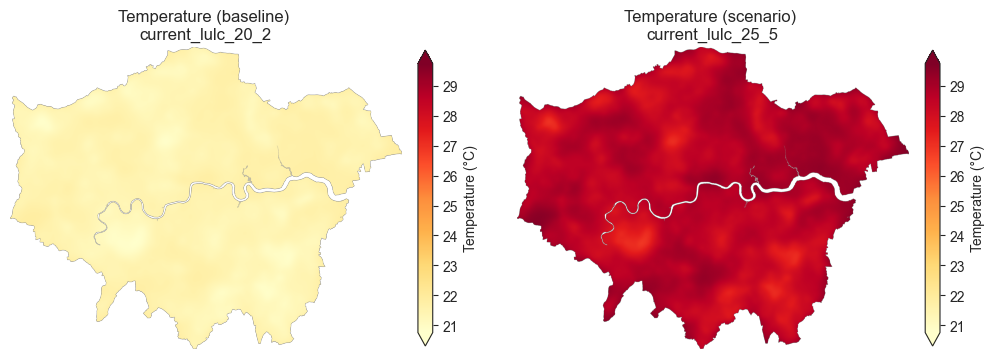

In [59]:
sns.set_style("white")  # 'whitegrid', 'darkgrid', etc. also available


# --- Step 2: Load, CLIP, and Visualize the Two Temperature Maps ---

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# CLIP to AOI instead of reading the full rasters  
temp1, t1_transform, t1_meta, extent = clip_raster_to_aoi_for_plot(temp1_path, aoi_adm)
temp2, t2_transform, t2_meta, _      = clip_raster_to_aoi_for_plot(temp2_path, aoi_adm)

# Get common vmin and vmax (excluding NaNs)
combined = np.concatenate([temp1.ravel(), temp2.ravel()])
combined = combined[~np.isnan(combined)]
vmin, vmax = np.nanmin(combined), np.nanmax(combined)

# Plot the first temperature map (already clipped)
im1 = axes[0].imshow(temp1, cmap="YlOrRd", vmin=vmin, vmax=vmax, extent=extent, origin="upper")
axes[0].set_title(f"Temperature (baseline) \n{suffix1}")
axes[0].set_axis_off()
plt.colorbar(im1, ax=axes[0], label="Temperature (°C)", extend='both', fraction=0.035, pad=0.04)

# Plot the second temperature map (already clipped)
im2 = axes[1].imshow(temp2, cmap="YlOrRd", vmin=vmin, vmax=vmax, extent=extent, origin="upper")
axes[1].set_title(f"Temperature (scenario) \n{suffix2}")
axes[1].set_axis_off()
plt.colorbar(im2, ax=axes[1], label="Temperature (°C)", extend='both', fraction=0.035, pad=0.04)

# Save the figure
f = f"temp_2_scenarios_{suffix_change}.png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [60]:
# Flatten the array and remove NaN values
temp_flat = temp1.ravel()
temp_flat = temp_flat[np.isfinite(temp_flat)]  # Remove NaNs

# Summary Statistics
summary_stats = pd.Series(temp_flat).describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
print("Summary Statistics:\n", summary_stats)

Summary Statistics:
 count    1.573396e+07
mean     2.142423e+01
std      1.779847e-01
min      2.075550e+01
1%       2.090704e+01
10%      2.118933e+01
25%      2.132103e+01
50%      2.144029e+01
75%      2.155351e+01
90%      2.163920e+01
99%      2.175132e+01
99.9%    2.183529e+01
max      2.189906e+01
dtype: float64


## T_air change 

In [61]:
# --- Step 3: Calculate Temperature Change ---
temp_change = temp2 - temp1  # Compute difference (Temp2 - Temp1)

# Mask unrealistic values (> 10 °C change)
temp_change = np.where(temp_change > 10, np.nan, temp_change)   # <<< CHANGED

from numpy.ma import masked_invalid
arr_masked = masked_invalid(temp_change.astype("float32"))


# Prepare metadata (float32 with a valid nodata)
out_meta = t1_meta.copy()                                    # <<< CHANGED
out_meta.update(dtype="float32", nodata=None)   # let rasterio infer



# Replace NaNs with nodata code
temp_change_out = np.where(np.isnan(temp_change), -9999.0, temp_change).astype("float32")  # <<< CHANGED

# Save the temperature change raster
with rasterio.open(temp_change_output_path, "w", **out_meta) as dst:
    dst.write(arr_masked.filled(-9999.0), 1)    # still writes a nodata code, but you control the masking

print(f"[OK] Temperature change raster saved → {temp_change_output_path}")

[OK] Temperature change raster saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\T_air_current_lulc_20_2_VS_current_lulc_25_5_change.tif


### change summary

In [62]:
# Flatten the array and remove NaN values
temp_change_flat = temp_change.ravel()
temp_change_flat = temp_change_flat[np.isfinite(temp_change_flat)]  # Remove NaNs

# Summary Statistics
summary_stats = pd.Series(temp_change_flat).describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999])
print("Summary Statistics:\n", summary_stats)



# Count pixels > 0
count = np.sum((temp_change > 0) & (~np.isnan(temp_change)))
print(f"Pixels with value > 0: {count}")



Summary Statistics:
 count    1.573396e+07
mean     7.136346e+00
std      2.669770e-01
min      6.133247e+00
1%       6.360566e+00
10%      6.783989e+00
25%      6.981539e+00
50%      7.160431e+00
75%      7.330261e+00
90%      7.458803e+00
99%      7.626976e+00
99.9%    7.752942e+00
max      7.848580e+00
dtype: float64
Pixels with value > 0: 15733955


### change viz - hist

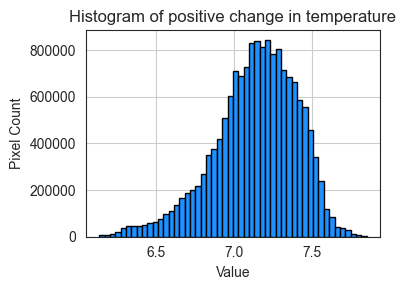

temp_change_hist_current_lulc_20_2_VS_current_lulc_25_5.png


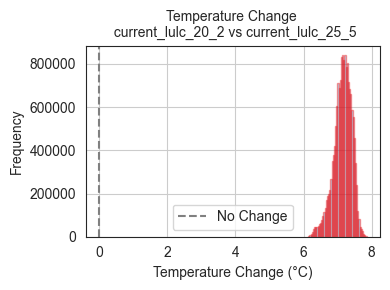

In [69]:

# --- Filter positive values only ---
positive_values = temp_change[temp_change > 0]

# --- Plot histogram if any positive values exist ---
if positive_values.size > 0:
    plt.figure(figsize=(4, 3))
    plt.hist(positive_values, bins=50, color="dodgerblue", edgecolor="black")
    plt.title("Histogram of positive change in temperature")
    plt.xlabel("Value")
    plt.ylabel("Pixel Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("No positive change in temperature.")





# --- Step 1: Histogram of Temperature Change ---
plt.figure(figsize=(4, 3))
plt.hist(temp_change_flat, bins=50, color="steelblue", alpha=0.4, edgecolor="red")
plt.axvline(x=0, color="gray", linestyle="--", label="No Change")  # Add a vertical line at 0
plt.xlabel("Temperature Change (°C)")
plt.ylabel("Frequency")
plt.title(f"Temperature Change \n {suffix1} vs {suffix2}", size = 10)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the figure
f = "temp_change_hist_" + suffix_change + ".png"; print(f)
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

plt.show()



# # Plot temperature change map
# fig, ax = plt.subplots(figsize=(8, 6))
# im = ax.imshow(temp_change, cmap="bwr", extent=extent, origin="upper")  # Blue-Red for changes
# plt.colorbar(im, label="Temperature Change (°C)")
# plt.title("Temperature Change (2000-2020)")
# plt.show()




### change map 1

In [64]:
import matplotlib.colors as mcolors


# Open the temperature change raster
with rasterio.open(temp_change_output_path) as src:
    temp_change = src.read(1, masked=True)  # stays as masked array
    
    # If nodata wasn’t written, you can mask -9999 on the fly:
    if src.nodata is None:
        temp_change = np.ma.masked_where(temp_change == -9999.0, temp_change)

    transform = src.transform  # Get transform info
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]



## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# # Check if all values are negative
# if np.nanmax(temp_change) <= 0:
#     cmap = "Blues"  # Use a single-hue blue color scale
# else:
#     cmap = "RdBu_r"  # Use diverging red-blue if both positive & negative exist

# # Define a custom normalization: zero values in white
# norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(temp_change), vcenter=0, vmax=np.nanmax(temp_change))
## ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## ----------------------------------------------------------
# Compute value distribution
min_val = np.nanmin(temp_change)
max_val = np.nanmax(temp_change)
print('max_val:', max_val)

# If all values are negative, use a single-hue colormap
# Decide colormap based on value range
if max_val <= 0:
    # all values <= 0 → use a blue scale
    cmap = "Blues"
elif min_val >= 0:
    # all values >= 0 → use a red scale
    cmap = "Reds"
else:
    # mixed positive and negative values → diverging
    cmap = "RdBu_r"


# Custom normalization: Zero in white, shorten positive range
if min_val < 0 < max_val:
    pos_percentile = np.percentile(temp_change[temp_change > 0], 70)  # Focus on 85% quantile for positive values
    norm = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=pos_percentile)
else:
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
## ----------------------------------------------------------


# # --- Plot ---
# fig, ax = plt.subplots(figsize=(10, 6))

# # Plot the temperature change raster
# im = ax.imshow(temp_change, cmap=cmap, norm=norm, extent=extent, origin="upper")

# # Overlay the shapefile boundary
# aoi_adm.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.7, label="Region Boundary")

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label("Temperature Change (°C)")

# # Formatting
# plt.title(f"Temperature Change \n {suffix1} vs {suffix2}")
# ax.set_axis_off()
# # plt.xlabel("Longitude")
# # plt.ylabel("Latitude")
# plt.grid(False)
# plt.legend()

# # Save the figure
# f = "temp_change_map_" + suffix_change + "_.png"
# output_plot_path = figures_dir / f
# plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# # Show the plot
# plt.show()



max_val: 7.8485804


### change map 2 - better

[6.133247375488281, 6.419136206309001, 6.70502503712972, 6.9909138679504395, 7.276802698771159, 7.562691529591879, 7.848580360412598]


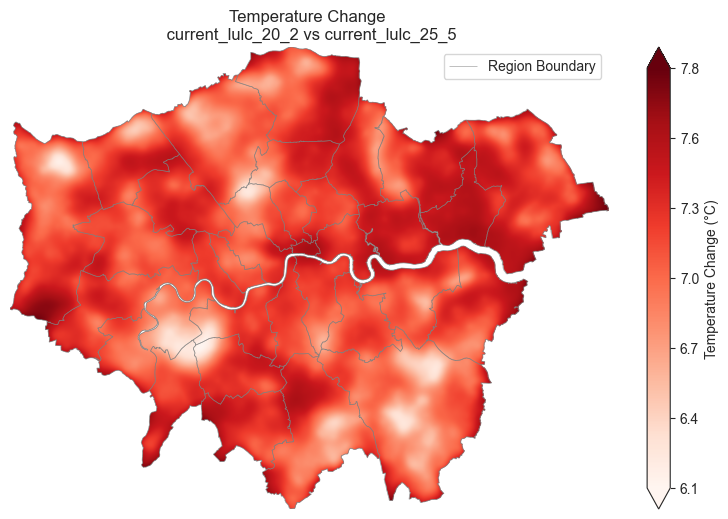

In [65]:

min_val = np.nanmin(temp_change)
max_val = np.nanmax(temp_change)

# Anchor at zero if there's negative and positive data
if min_val < 0 and max_val > 0:
    vcenter = 0
else:
    vcenter = (min_val + max_val) / 2

# Avoid degenerate color range
if min_val >= max_val:
    max_val = min_val + 1e-6

# Build color norm: negative=red, positive=blue
norm = mcolors.TwoSlopeNorm(vmin=min_val, vcenter=vcenter, vmax=max_val)
color_map = plt.cm.RdBu


# -------------------------------
# Enhanced Colorbar Definition
# -------------------------------
# We'll create a set of ticks that includes min_val, 0 (if in range), and max_val,
# plus extra ticks for intermediate values.

ticks = [min_val]
# If zero is in range, add it
if min_val < 0 < max_val:
    ticks.append(0)
# Then add the max_val
ticks.append(max_val)

# Optionally, add intermediate steps. For example, 3 extra steps between min->0 and 3 extra steps between 0->max.
# You can fine-tune how many intermediate ticks you want.
num_intermediates = 3
if min_val < 0 < max_val:
    neg_ticks = np.linspace(min_val, 0, num_intermediates + 4)  # exclude endpoints
    pos_ticks = np.linspace(0, max_val, num_intermediates + 1)
    ticks = np.concatenate([neg_ticks, [0], pos_ticks])
else:
    # If purely negative or purely positive, just do a simple linear space
    ticks = np.linspace(min_val, max_val, num_intermediates + 4)

ticks = sorted(list(set(ticks)))  # Ensure sorted and unique

print(ticks)

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the temperature change raster
im = ax.imshow(temp_change, cmap=cmap, norm=norm, extent=extent, origin="upper")

# Overlay the shapefile boundary
aoi_adm.boundary.plot(ax=ax, edgecolor="gray", linewidth=0.5, alpha=0.7, label="Region Boundary")

# Add colorbar with adjusted scale
cbar = plt.colorbar(im, ax=ax, extend = 'both')
cbar.ax.set_yscale('linear')
cbar.set_label("Temperature Change (°C)")
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels([f"{t:.1f}" for t in ticks])

# Formatting
plt.title(f"Temperature Change \n {suffix1} vs {suffix2}")
ax.set_axis_off()
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
plt.grid(False)
plt.legend()

# Save the figure
f = "temp_change_map_" + suffix_change + ".png"
output_plot_path = figures_dir / f
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# Show the plot
plt.show()

### change by Borough - csv

In [66]:
from rasterstats import zonal_stats

# --- Step 5: Violin Plot by Administrative Region ---
# Compute zonal statistics (mean temperature change per region)
zonal_stats_result = zonal_stats(
    aoi_adm, 
    str(temp_change_output_path),   # (ok to pass Path, but string is safest)
    nodata=-9999.0,  # whatever you wrote as nodata
    geojson_out=True,
    stats=["mean"])


# Convert to GeoDataFrame to keep properties + geometry
import geopandas as gpd
zs_gdf = gpd.GeoDataFrame.from_features(zonal_stats_result)
# print(zs_gdf.head())


# Convert zonal stats to DataFrame
df_zonal = pd.DataFrame(zs_gdf)

# Rename 'mean' → 'temp_change_mean'
df_zonal = df_zonal.rename(columns={"mean": "temp_change_mean"}) 

# Drop unwanted columns
cols_to_drop = ["HECTARES", "NONLD_AREA", "ONS_INNER", "SUB_2009", "SUB_2006", "geometry"]
df_zonal = df_zonal.drop(columns=cols_to_drop, errors="ignore")  # <<< errors="ignore" skips if not present



# save the zonal stats to CSV
zonal_stats_csv_path = dir_ucm_out / "ucm_output_postprocess" / f"zonal_stats_temp_change_{suffix_change}.csv"
df_zonal.to_csv(zonal_stats_csv_path, index=False)
print(f"[OK] Zonal stats saved → {zonal_stats_csv_path}")

[OK] Zonal stats saved → G:\Shared drives\Wellcome Trust Project Data\2_postprocess_intermediate\UCM_official_runs\ucm_output_postprocess\zonal_stats_temp_change_current_lulc_20_2_VS_current_lulc_25_5.csv


### change plot - violin

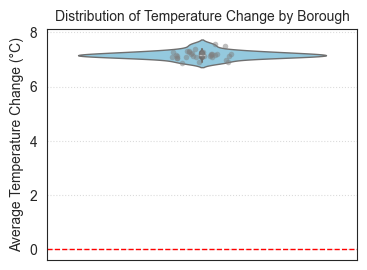

In [68]:

# Plot Violin Plot with Jittered Points
fig, ax = plt.subplots(figsize=(4, 3)) 

# Violin Plot (Temperature Change Distribution by Region)
sns.violinplot(y=df_zonal["temp_change_mean"], 
            
               color="skyblue",
               linewidth=1,  # Border thickness
               # inner="quartile", 
               # inner_kws=dict(box_width=25, whis_width=4, color="silver")
               # line_kws={"color": "red", "linewidth": 5}  # Custom quartile line color
               ax=ax  # <<< CHANGED: explicit Axes
               )

# Jittered Points (to show actual data points)
sns.stripplot(
    y=df_zonal["temp_change_mean"], 
    color="gray", 
    size=4, 
    jitter=True, 
    alpha=0.5, 
    ax=ax)

# Horizontal reference line at 0
ax.axhline(0, color="red", linestyle="--", linewidth=1)  # <<< NEW


# Labels & Formatting
# Labels & Formatting
ax.set_ylabel("Average Temperature Change (°C)")  # <<< CHANGED: use ax
ax.set_title("Distribution of Temperature Change by Borough", size = 10)
ax.grid(True, axis="y", linestyle=":", alpha=0.7)  # <<< CHANGED: lighter grid, y-only

# Save plot
f = f"temp_change_violin_Borough_{suffix_change}.png"
output_plot_path = figures_dir / f 
plt.savefig(output_plot_path, dpi=300, bbox_inches="tight", transparent=True)

# Show Plot
plt.show()